In [2]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
from scipy.stats import lognorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
from scipy import stats
from scipy.stats import norm, kstest

In [27]:
dfile = os.path.join(DATA_PATH, 'zen.2458116.34176.xx.HH.uvOCRS')
uvd = UVData()
uvd.read(dfile)

print(uvd.Nbls,uvd.Nfreqs, uvd.Nspws, uvd.Ntimes)
#print(dir(uvd))

1378 1024 1 60


In [4]:
cosmo = hp.conversions.Cosmo_Conversions()
print(cosmo)

Cosmo_Conversions object at <0x10aa2f0b8>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


In [5]:
# Creating the beamfile
beam_freqs = uvd.freq_array # in Hz
uvb = hp.PSpecBeamGauss(fwhm=0.21170844, beam_freqs=beam_freqs[0])

In [6]:
# Converting units
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='pI')
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [7]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)         #even
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)          #odd

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [8]:
ds.rephase_to_dset(0)

In [9]:
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [10]:
# Specify which baselines to include
baselines = [(1, 120), (1, 121), (1, 122)]
# baselines = [(23, 23), (23, 24), (23, 25)]

In [11]:
# Define uvp
# Polarization pairs for this specific simulation data is 'pI'
# spw_range length = number of delays
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(800, 1000)],  
               input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True)   


Setting spectral range: (800, 1000)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((1, 120), (1, 120))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((1, 121), (1, 121))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((1, 122), (1, 122))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


Text(0.5, 1.0, "spw : 0, blpair : ((1, 120), (1, 120)), pol : ('xx', 'xx')")

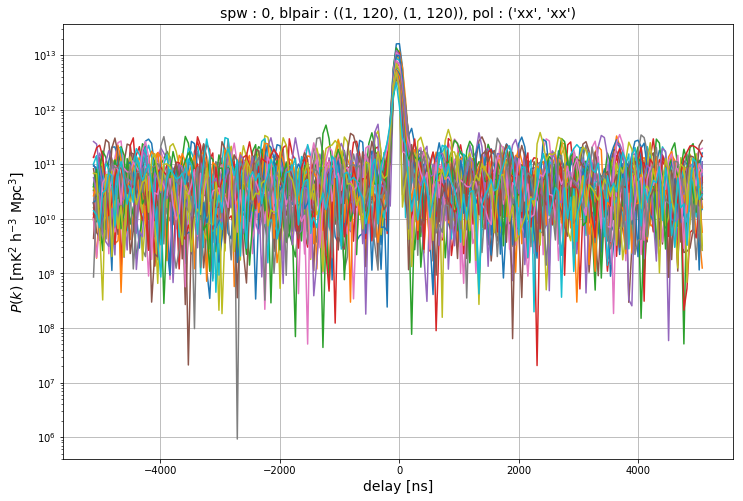

In [12]:
# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp = ((1, 120), (1, 120))
pol = ('xx', 'xx')
key = (spw, blp, pol)
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

In [16]:
# form the baseline-pair group, which will be a single group 
# consisting of all baseline-pairs in the object
blp_group = [sorted(np.unique(uvp.blpair_array))]

# average spectra with inplace = False and assign to a new "uvp2" object
uvp2 = uvp.average_spectra(blpair_groups=blp_group, time_avg=True, inplace=False)

In [17]:
# return the nearest delay (in the dlys array) from the rough input delay
def get_delay(dly, key):
    dlys = uvp.get_dlys(key[0]) * 1e9
    dlys = np.asarray(dlys)
    idx = (np.abs(dlys - dly)).argmin()
    return dlys[idx]

In [18]:
# create a list of P(k) in a chosen delay interval or at a specific delay
def power_hist(i_dly, f_dly, key):
    power = np.real(uvp.get_data(key))
    ini_dly = get_delay(i_dly, key)
    fin_dly = get_delay(f_dly, key)
    dlys = uvp.get_dlys(key[0]) * 1e9
    i_index = int(np.where(dlys == ini_dly)[0])
    f_index = int(np.where(dlys == fin_dly)[0])
    print(i_index, f_index)
    y = []
    power = power.T
    for i in range(int(f_index-i_index)+1):
        for j in range(len(power[i])):
            y.append(power[int(i+i_index)][j])
    return(y)

139 178


Text(0.5, 1.0, "spw : 0, blpair : ((1, 120), (1, 120)), pol : ('xx', 'xx'), dlys : 1996ns to 3993ns")

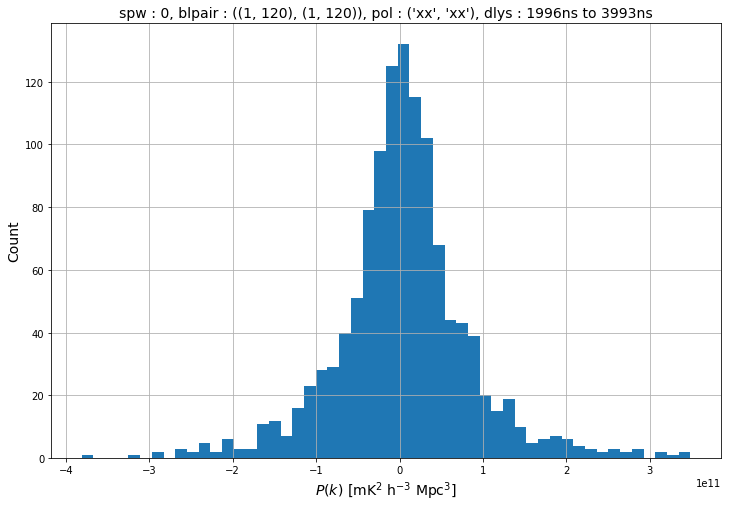

In [20]:
# plot a histogram of P(k)
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp = ((1, 120), (1, 120))
pol = ('xx', 'xx')
key = (spw, blp, pol)
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))
dly = [2000, 4000]
ini_dly = int(get_delay(dly[0], key))
fin_dly = int(get_delay(dly[1], key))
txt = (spw, blp, pol, ini_dly, fin_dly)

p = power_hist(dly[0], dly[1], key)

_ = ax.hist(p, bins='auto')
ax.grid()
ax.set_xlabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_ylabel(r"Count", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}, dlys : {}ns to {}ns".format(*txt), fontsize=14)

139 178


Text(0.5, 1.0, "spw : 0, blpair : ((1, 120), (1, 120)), pol : ('xx', 'xx'), dlys : 1996ns ~ 3993ns")

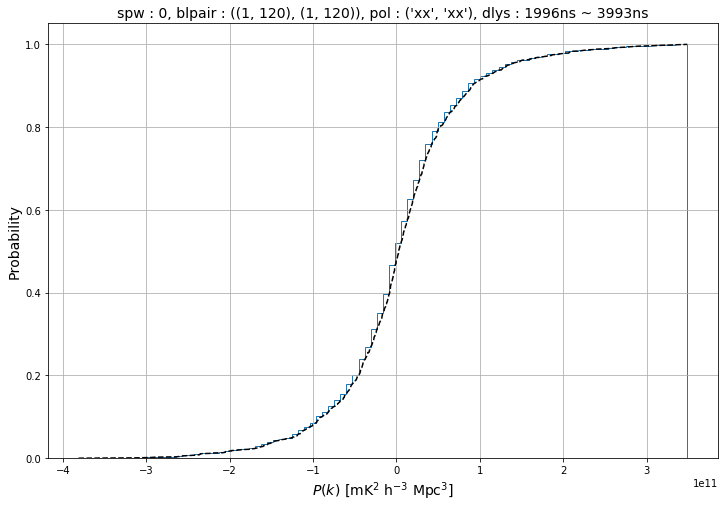

In [21]:
# cumulative distribution function
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp = ((1, 120), (1, 120))
pol = ('xx', 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))
dly = [2000, 4000]
key = (spw, blp, pol)
ini_dly = int(get_delay(dly[0], key))
fin_dly = int(get_delay(dly[1], key))
txt = (spw, blp, pol, ini_dly, fin_dly)

p = power_hist(dly[0], dly[1], key)
cdf = np.array(range(len(p)))/float(len(p))

n, bins, patches = ax.hist(p, bins=100, density=True, histtype='step', cumulative=True)
ax.plot(np.sort(p), cdf, 'k--')
# ax.hist(p, bins=bins, density=True, histtype='step', cumulative=-1)
ax.grid()
ax.set_xlabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_ylabel(r"Probability", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}, dlys : {}ns ~ {}ns".format(*txt), fontsize=14)

In [22]:
def plot_kstest(x, data, x_delay=False, alpha=0.05):
    """
    H0: dist1 = dist2
    d < critical value, p-value > alpha -->> accept H0
    ------
    x: 1d array (time, delay mode)
    data: 2d array (visibility, power)
    x_delay: is x axis delay? (default: False)
    alpha: significance level (default: 0.05)
    ------
    Data matrix rows -->> time sample
    Data matrix columns -->> frequency/delay mode
    """
    
    if x_delay:
        data = np.transpose(data)
    
    # fit each dataset with a normal distribution
    mu = []
    std = []
    for i in range(len(data)):
        mu.append(norm.fit(data[i])[0])
        std.append(norm.fit(data[i])[1])
        
    # get cdf of each dataset
    cdf = []
    for i in range(len(data)):
        cdf.append(np.array(range(len(data[i])))/float(len(data[i])))
    
    # get cdf of each fit
    norm_cdf = []
    for i in range(len(data)):
        norm_cdf.append(norm.cdf(np.sort(data[i]), mu[i], std[i]))
    
    # perform KS test between each empirical dataset with its corresponding normal distribution
    # get d (KS statistic) and p-values
    d = []
    p = []
    for i in range(len(data)):
        d.append(stats.ks_2samp(cdf[i], norm_cdf[i])[0])
        p.append(stats.ks_2samp(cdf[i], norm_cdf[i])[1])
    
    # get critical value (significance level = 0.05) (by the AD-test function)
    cv = []
    for i in range(len(data)):
        cv.append(stats.anderson_ksamp([cdf[i], norm_cdf[i]])[1][2])
    
    # plot cdf if the number of datasets is small
    if len(data) < 16:
        plt.figure(figsize=(12, 12))
        for i in range(1, len(cv)+1):
            plt.subplot(6, 4, i)
            i -= 1
            plt.plot(np.sort(data[i]), norm_cdf[i],'b--')
            plt.plot(np.sort(data[i]), cdf[i], 'r-')
            plt.grid()
    
    # plot KS test results
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot
    ax.plot(x, d, 'r-', label='KS statistics')
    ax.plot
    ax.plot(x, cv, 'b--', label='Critical values')
    ax.grid()
    ax.legend()
    
    # plot KS test results
    plt.subplot(2, 1, 1)
    plt.plot(x, [alpha for i in range(len(x))], 'k--', label='Significance level')
    plt.plot(x, p, 'g.', label="p values")
    plt.legend()
    plt.ylabel("Probability", fontsize=14)
    if x_delay:
        plt.title("Kolmogorov-Smirnov Test byDelay Mode ")
    else:
        plt.title("Kolmogorov-Smirnov Test by Time Sample")
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(x, cv, 'b--', label='Critical values')
    plt.plot(x, d, 'r.', label='KS statistics')
    plt.legend()
    plt.ylabel("Statistics", fontsize=14)
    if x_delay:
        plt.xlabel("Delay (ns)", fontsize=14)
    else:
        plt.xlabel("Time sample", fontsize=14)
    plt.grid()
    plt.show()

In [23]:
def plot_adtest(x, data, x_delay=False):
    """
    H0: dist1 = dist2
    AD statistic < critical value -->> accept H0
    ------
    x: 1d array (time, delay mode)
    data: 2d array (visibility, power)
    x_delay: is x axis delay? (default: False)
    ------
    Data matrix rows -->> time sample
    Data matrix columns -->> frequency/delay mode
    """

    if x_delay:
        data = np.transpose(data)
    
    # fit each dataset with a normal distribution
    mu = []
    std = []
    for i in range(len(data)):
        mu.append(norm.fit(data[i])[0])
        std.append(norm.fit(data[i])[1])
        
    # get cdf of each dataset
    cdf = []
    for i in range(len(data)):
        cdf.append(np.array(range(len(data[i])))/float(len(data[i])))
    
    # get cdf of each fit
    norm_cdf = []
    for i in range(len(data)):
        norm_cdf.append(norm.cdf(np.sort(data[i]), mu[i], std[i]))
    
    # perform AD test between each empirical dataset with its corresponding normal distribution
    # get a (AD statistic) and critical values
    a = []
    for i in range(len(data)):
        a.append(stats.anderson_ksamp([cdf[i], norm_cdf[i]])[0])
    cv = stats.anderson_ksamp([cdf[i], norm_cdf[i]])[1]
    
    # plot cdf if the number of datasets is small
    if len(data) < 16:
        plt.figure(figsize=(12, 12))
        for i in range(1, len(a)+1):
            plt.subplot(6, 4, i)
            i -= 1
            plt.plot(np.sort(data[i]), norm_cdf[i],'b--')
            plt.plot(np.sort(data[i]), cdf[i], 'r-')
            plt.grid()
    # plot AD test results
    plt.figure(figsize=(12,4))
    plt.plot(x, a, '.')
    for i in range(len(cv)):
        plt.plot(x, [cv[i] for j in range(len(x))], '--')
    labels = ["AD statistics", "1%", "2.5%", "5%", "10%", "15%"]
    plt.ylabel("Statistics", fontsize=14)
    if x_delay:
        plt.xlabel("Delay (ns)", fontsize=14)
        plt.title("Anderson-Darling Test by Delay Mode")
    else: 
        plt.xlabel("Time sample", fontsize=14)
        plt.title("Anderson-Darling Test by Time Sample")
    plt.grid()
    plt.legend(labels, ncol=4, loc='upper center')

In [24]:
f_index = 178
i_index = 139

p = []
for i in range(f_index-i_index):
    p.append(power.T[i_index+i])

p-value capped: true value larger than 0.25


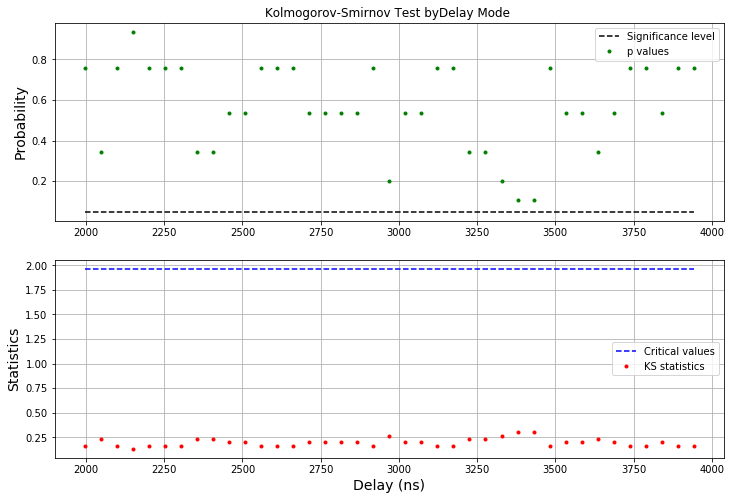

In [25]:
plot_kstest(dlys[i_index:f_index], np.transpose(p), x_delay=True)

p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25


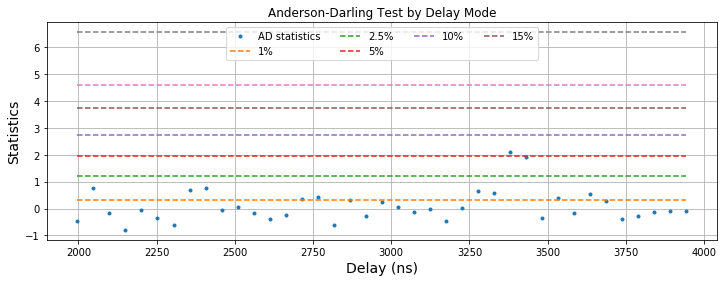

In [26]:
plot_adtest(dlys[i_index:f_index], np.transpose(p), x_delay=True)